In [1]:
import numpy as np
from scipy import signal 
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
def function_gen(x, a, b, c, d):
    y1 = a*x**2 +b*x+c
    y2 = d*x**3 + c*x**2 + b*x+a
    return y1, y2

In [40]:
x = np.linspace(0,1,100)

y1 = []
y2 = []
a = []
b = []
c = []
d = []

for i in range(10000):

    a_ = np.random.normal(8, 1.5, 1)
    b_ = np.random.normal(2, 2, 1)
    c_ = np.random.normal(4, 1, 1)
    d_ = np.random.normal(0, 0.5, 1)

    y1_, y2_ = function_gen(x, a_, b_, c_, d_)
    
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)

In [4]:
reg1 = np.polyfit(x,y1[0],3)

In [5]:
reg1

array([1.17643003e-14, 7.80103103e+00, 5.34953225e+00, 4.37792966e+00])

In [6]:
print(a[0],b[0],c[0],d[0])

[7.80103103] [5.34953225] [4.37792966] [-0.31021509]


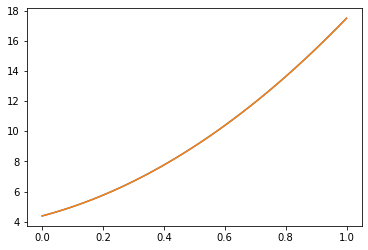

In [7]:
plt.plot(x, np.polyval(reg1,x))
plt.plot(x, y1[0])

In [8]:
reg2 = np.polyfit(x,y2[0],4)

In [9]:
reg2

array([ 2.29353912e-13, -3.10215089e-01,  4.37792966e+00,  5.34953225e+00,
        7.80103103e+00])

In [10]:
print(a[0],b[0],c[0],d[0])

[7.80103103] [5.34953225] [4.37792966] [-0.31021509]


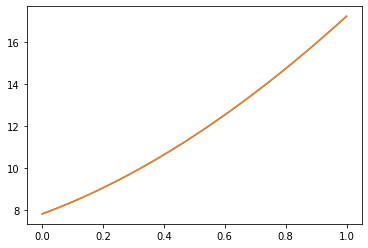

In [11]:
plt.plot(x, np.polyval(reg2,x))
plt.plot(x, y2[0])

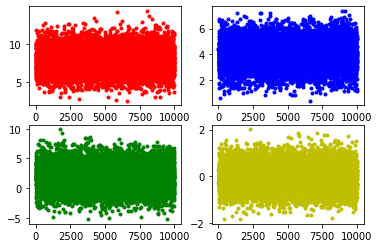

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=2)

axs[0,0].plot(np.asarray(a),'r.')
axs[1,0].plot(np.asarray(b),'g.')
axs[0,1].plot(np.asarray(c),'b.')
axs[1,1].plot(np.asarray(d),'y.')

In [13]:
series1 = np.rollaxis(np.asarray(y1),1)
series2 = np.rollaxis(np.asarray(y2),1)

In [14]:
# # defines the model
# model = Sequential()
# model.add(Bidirectional())

In [15]:
import keras as K

Using TensorFlow backend.


In [16]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense


import keras
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [17]:
def rnn_auto(layer, size, num_encode_layers, num_decode_layers, embedding, n_step, lr = 3e-5, drop_frac=0.,bidirectional=True, l1_norm = 1e-4,**kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    num_encode_layers  : numpy, int
        sets the number of encoding layers in the network
    num_decode_layers : numpy, int
        sets the number of decoding layers in the network
    embedding : numpy, int
        sets the size of the embedding layer
    n_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidirectional : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    # defines the model
    model = Sequential()

    # selects if the model is bidirectional
    if bidirectional:
        wrapper = Bidirectional
        # builds the first layer
        model.add(Bidirectional(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac),
                            input_shape=(n_step, 1)))
    else:
        wrapper = lambda x: x
        # builds the first layer
        model.add(wrapper(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac,
                input_shape=(n_step, 1))))

    # builds the encoding layers
    for i in range(1, num_encode_layers):
        model.add(wrapper(layer(size, return_sequences=(i < num_encode_layers - 1), dropout=drop_frac)))

    # builds the embedding layer
    if l1_norm == None:
        # embedding layer without l1 regulariization
        model.add(Dense(embedding, activation='relu', name='encoding'))
    else:
        # embedding layer with l1 regularization
        model.add(Dense(embedding, activation='relu', name='encoding',activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(n_step))

    # builds the decoding layer
    for i in range(num_decode_layers):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. The batch
        size is limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                             save_weights_only=True, mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data1), np.atleast_3d(data2), epochs=250000,
          batch_size=1200, validation_data=(np.atleast_3d(data), np.atleast_3d(data)),
          callbacks=[tbCallBack, checkpoint])


In [22]:
auto_test = rnn_auto(LSTM, 64, 1, 1, 10, 100)

In [56]:
# fits the model
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=2500, batch_size=2000)

Epoch 1/2500
10000/10000 [==============================] - 4s 382us/step - loss: 2.5544
Epoch 2/2500
10000/10000 [==============================] - 4s 373us/step - loss: 2.5485
Epoch 3/2500
10000/10000 [==============================] - 4s 376us/step - loss: 2.5417
Epoch 4/2500
10000/10000 [==============================] - 4s 384us/step - loss: 2.5346
Epoch 5/2500
10000/10000 [==============================] - 4s 379us/step - loss: 2.5285
Epoch 6/2500
10000/10000 [==============================] - 4s 376us/step - loss: 2.5227
Epoch 7/2500
10000/10000 [==============================] - 4s 375us/step - loss: 2.5161
Epoch 8/2500
10000/10000 [==============================] - 4s 392us/step - loss: 2.5099
Epoch 9/2500
10000/10000 [==============================] - 4s 375us/step - loss: 2.5028
Epoch 10/2500
10000/10000 [==============================] - 4s 384us/step - loss: 2.4957
Epoch 11/2500
10000/10000 [==============================] - 4s 379us/step - loss: 2.4899
Epoch 12/2500
10000

10000/10000 [==============================] - 4s 374us/step - loss: 2.0110
Epoch 93/2500
10000/10000 [==============================] - 4s 378us/step - loss: 2.0070
Epoch 94/2500
10000/10000 [==============================] - 4s 376us/step - loss: 2.0009
Epoch 95/2500
10000/10000 [==============================] - 4s 378us/step - loss: 1.9961
Epoch 96/2500
10000/10000 [==============================] - 4s 376us/step - loss: 1.9920
Epoch 97/2500
10000/10000 [==============================] - 4s 379us/step - loss: 1.9878
Epoch 98/2500
10000/10000 [==============================] - 4s 377us/step - loss: 1.9816
Epoch 99/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.9766
Epoch 100/2500
10000/10000 [==============================] - 4s 378us/step - loss: 1.9720
Epoch 101/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.9675
Epoch 102/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.9620
Epoch 103/2500
10000/

10000/10000 [==============================] - 4s 376us/step - loss: 1.3808
Epoch 273/2500
10000/10000 [==============================] - 4s 376us/step - loss: 1.3809
Epoch 274/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.3763
Epoch 275/2500
10000/10000 [==============================] - 4s 376us/step - loss: 1.3754
Epoch 276/2500
10000/10000 [==============================] - 4s 377us/step - loss: 1.3706
Epoch 277/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.3679
Epoch 278/2500
10000/10000 [==============================] - 4s 377us/step - loss: 1.3649
Epoch 279/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.3624
Epoch 280/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.3593
Epoch 281/2500
10000/10000 [==============================] - 4s 374us/step - loss: 1.3562
Epoch 282/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.3534
Epoch 283/2500

10000/10000 [==============================] - 4s 377us/step - loss: 0.9880
Epoch 453/2500
10000/10000 [==============================] - 4s 375us/step - loss: 0.9844
Epoch 454/2500
10000/10000 [==============================] - 4s 374us/step - loss: 0.9840
Epoch 455/2500
10000/10000 [==============================] - 4s 375us/step - loss: 0.9819
Epoch 456/2500
10000/10000 [==============================] - 4s 376us/step - loss: 0.9794
Epoch 457/2500
10000/10000 [==============================] - 4s 375us/step - loss: 0.9786
Epoch 458/2500
10000/10000 [==============================] - 4s 377us/step - loss: 0.9762
Epoch 459/2500
10000/10000 [==============================] - 4s 377us/step - loss: 0.9743
Epoch 460/2500
10000/10000 [==============================] - 4s 375us/step - loss: 0.9718
Epoch 461/2500
10000/10000 [==============================] - 4s 376us/step - loss: 0.9702
Epoch 462/2500
10000/10000 [==============================] - 4s 377us/step - loss: 0.9696
Epoch 463/2500

KeyboardInterrupt: 

In [57]:
auto_test.save('auto_test')

In [58]:
y1_results = auto_test.predict(np.atleast_3d(y1))

In [59]:
y1_results

array([[[ 5.703536 ],
        [ 5.8067884],
        [ 5.8990645],
        ...,
        [10.774312 ],
        [10.458518 ],
        [10.168419 ]],

       [[ 8.12177  ],
        [ 8.245468 ],
        [ 8.355945 ],
        ...,
        [11.416098 ],
        [10.837579 ],
        [10.361101 ]],

       [[ 8.297416 ],
        [ 8.457934 ],
        [ 8.602529 ],
        ...,
        [12.0900135],
        [11.214003 ],
        [10.538136 ]],

       ...,

       [[ 8.600521 ],
        [ 8.858601 ],
        [ 9.098157 ],
        ...,
        [13.31704  ],
        [11.909701 ],
        [10.839916 ]],

       [[ 4.979612 ],
        [ 5.081118 ],
        [ 5.171499 ],
        ...,
        [10.720121 ],
        [10.425514 ],
        [10.14757  ]],

       [[ 7.2520633],
        [ 7.3573656],
        [ 7.449191 ],
        ...,
        [11.20881  ],
        [10.7185   ],
        [10.300197 ]]], dtype=float32)

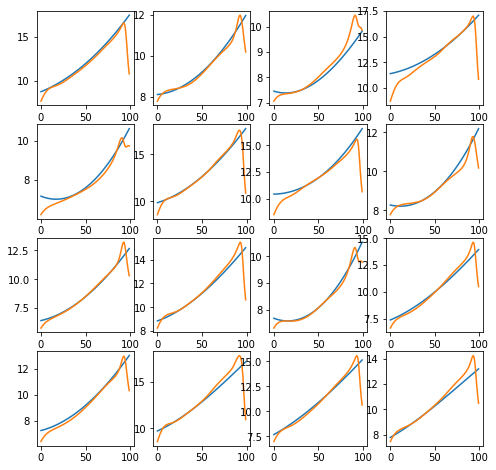

In [60]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, y1_results.shape[0])
        ax = axs[i,j]
        ax.plot(y2[k])
        ax.plot(y1_results[k])

In [61]:
auto_test = rnn_auto(LSTM, 64, 2, 2, 10, 100)
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=2500, batch_size=2000)

Epoch 1/2500
10000/10000 [==============================] - 11s 1ms/step - loss: 113.0746
Epoch 2/2500
10000/10000 [==============================] - 10s 954us/step - loss: 111.8205
Epoch 3/2500
10000/10000 [==============================] - 9s 945us/step - loss: 110.4172
Epoch 4/2500
10000/10000 [==============================] - 9s 943us/step - loss: 108.8167
Epoch 5/2500
10000/10000 [==============================] - 9s 933us/step - loss: 107.0193
Epoch 6/2500
10000/10000 [==============================] - 9s 929us/step - loss: 104.9835
Epoch 7/2500
10000/10000 [==============================] - 9s 932us/step - loss: 102.6953
Epoch 8/2500
10000/10000 [==============================] - 9s 928us/step - loss: 100.1487
Epoch 9/2500
10000/10000 [==============================] - 9s 939us/step - loss: 97.3310
Epoch 10/2500
10000/10000 [==============================] - 9s 931us/step - loss: 94.2517
Epoch 11/2500
10000/10000 [==============================] - 9s 925us/step - loss: 90.9375


10000/10000 [==============================] - 9s 916us/step - loss: 10.1000
Epoch 92/2500
10000/10000 [==============================] - 9s 920us/step - loss: 10.0689
Epoch 93/2500
10000/10000 [==============================] - 9s 924us/step - loss: 10.0375
Epoch 94/2500
10000/10000 [==============================] - 9s 915us/step - loss: 10.0058
Epoch 95/2500
10000/10000 [==============================] - 9s 911us/step - loss: 9.9736
Epoch 96/2500
10000/10000 [==============================] - 9s 914us/step - loss: 9.9407
Epoch 97/2500
10000/10000 [==============================] - 9s 913us/step - loss: 9.9064
Epoch 98/2500
10000/10000 [==============================] - 9s 924us/step - loss: 9.8705
Epoch 99/2500
10000/10000 [==============================] - 9s 922us/step - loss: 9.8322
Epoch 100/2500
10000/10000 [==============================] - 9s 940us/step - loss: 9.7914
Epoch 101/2500
10000/10000 [==============================] - 9s 943us/step - loss: 9.7491
Epoch 102/2500
100

10000/10000 [==============================] - 9s 914us/step - loss: 1.5400
Epoch 272/2500
10000/10000 [==============================] - 9s 916us/step - loss: 1.5319
Epoch 273/2500
10000/10000 [==============================] - 9s 914us/step - loss: 1.5210
Epoch 274/2500
10000/10000 [==============================] - 9s 918us/step - loss: 1.5112
Epoch 275/2500
10000/10000 [==============================] - 9s 916us/step - loss: 1.5001
Epoch 276/2500
10000/10000 [==============================] - 9s 919us/step - loss: 1.4895
Epoch 277/2500
10000/10000 [==============================] - 9s 917us/step - loss: 1.4781
Epoch 278/2500
10000/10000 [==============================] - 9s 916us/step - loss: 1.4693
Epoch 279/2500
10000/10000 [==============================] - 9s 913us/step - loss: 1.4626
Epoch 280/2500
10000/10000 [==============================] - 9s 919us/step - loss: 1.4506
Epoch 281/2500
10000/10000 [==============================] - 9s 914us/step - loss: 1.4404
Epoch 282/2500

10000/10000 [==============================] - 9s 917us/step - loss: 0.5572
Epoch 452/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.5570
Epoch 453/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.5642
Epoch 454/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.5628
Epoch 455/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.5502
Epoch 456/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.5490
Epoch 457/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.5468
Epoch 458/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.5407
Epoch 459/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.5376
Epoch 460/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.5360
Epoch 461/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.5368
Epoch 462/2500

10000/10000 [==============================] - 9s 914us/step - loss: 0.3264
Epoch 632/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.3256
Epoch 633/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.3286
Epoch 634/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.3264
Epoch 635/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.3229
Epoch 636/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.3216
Epoch 637/2500
10000/10000 [==============================] - 9s 920us/step - loss: 0.3215
Epoch 638/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.3264
Epoch 639/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.3238
Epoch 640/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.3262
Epoch 641/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.3305
Epoch 642/2500

10000/10000 [==============================] - 9s 914us/step - loss: 0.2422
Epoch 812/2500
10000/10000 [==============================] - 9s 911us/step - loss: 0.2354
Epoch 813/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.2276
Epoch 814/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.2269
Epoch 815/2500
10000/10000 [==============================] - 9s 911us/step - loss: 0.2264
Epoch 816/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.2249
Epoch 817/2500
10000/10000 [==============================] - 9s 911us/step - loss: 0.2244
Epoch 818/2500
10000/10000 [==============================] - 9s 909us/step - loss: 0.2234
Epoch 819/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.2231
Epoch 820/2500
10000/10000 [==============================] - 9s 910us/step - loss: 0.2228
Epoch 821/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.2219
Epoch 822/2500

10000/10000 [==============================] - 9s 914us/step - loss: 0.1773
Epoch 992/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1745
Epoch 993/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1750
Epoch 994/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1751
Epoch 995/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1739
Epoch 996/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1726
Epoch 997/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1717
Epoch 998/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1724
Epoch 999/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1729
Epoch 1000/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.1756
Epoch 1001/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1774
Epoch 1002/2

10000/10000 [==============================] - 9s 915us/step - loss: 0.1462
Epoch 1170/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1463
Epoch 1171/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1500
Epoch 1172/2500
10000/10000 [==============================] - 9s 908us/step - loss: 0.1455
Epoch 1173/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1434
Epoch 1174/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1459
Epoch 1175/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.1431
Epoch 1176/2500
10000/10000 [==============================] - 9s 911us/step - loss: 0.1444
Epoch 1177/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1409
Epoch 1178/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.1425
Epoch 1179/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.1423
Epoc

10000/10000 [==============================] - 9s 916us/step - loss: 0.1185
Epoch 1348/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1209
Epoch 1349/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.1210
Epoch 1350/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1189
Epoch 1351/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1214
Epoch 1352/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.1192
Epoch 1353/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1205
Epoch 1354/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1196
Epoch 1355/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1223
Epoch 1356/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.1287
Epoch 1357/2500
10000/10000 [==============================] - 9s 919us/step - loss: 0.1259
Epoc

10000/10000 [==============================] - 9s 922us/step - loss: 0.1096
Epoch 1526/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.1153
Epoch 1527/2500
10000/10000 [==============================] - 9s 922us/step - loss: 0.1316
Epoch 1528/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1382
Epoch 1529/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.1223
Epoch 1530/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1228
Epoch 1531/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.1149
Epoch 1532/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.1175
Epoch 1533/2500
10000/10000 [==============================] - 9s 920us/step - loss: 0.1317
Epoch 1534/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.1184
Epoch 1535/2500
10000/10000 [==============================] - 9s 919us/step - loss: 0.1154
Epoc

10000/10000 [==============================] - 9s 919us/step - loss: 0.1167
Epoch 1704/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.1069
Epoch 1705/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.0992
Epoch 1706/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.0973
Epoch 1707/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.1012
Epoch 1708/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.0998
Epoch 1709/2500
10000/10000 [==============================] - 9s 922us/step - loss: 0.1039
Epoch 1710/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.0940
Epoch 1711/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.0944
Epoch 1712/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.0960
Epoch 1713/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.0993
Epoc

10000/10000 [==============================] - 9s 918us/step - loss: 0.0887
Epoch 1882/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.0871
Epoch 1883/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.0872
Epoch 1884/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.0975
Epoch 1885/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.0853
Epoch 1886/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.0855
Epoch 1887/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.0872
Epoch 1888/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.0900
Epoch 1889/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.0868
Epoch 1890/2500
10000/10000 [==============================] - 9s 920us/step - loss: 0.0867
Epoch 1891/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.0958
Epoc

10000/10000 [==============================] - 9s 924us/step - loss: 0.0875
Epoch 2060/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0933
Epoch 2061/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0940
Epoch 2062/2500
10000/10000 [==============================] - 9s 924us/step - loss: 0.0972
Epoch 2063/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.1010
Epoch 2064/2500
10000/10000 [==============================] - 9s 924us/step - loss: 0.1060
Epoch 2065/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.1014
Epoch 2066/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.0949
Epoch 2067/2500
10000/10000 [==============================] - 9s 923us/step - loss: 0.0851
Epoch 2068/2500
10000/10000 [==============================] - 9s 922us/step - loss: 0.0834
Epoch 2069/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.0810
Epoc

10000/10000 [==============================] - 9s 927us/step - loss: 0.0820
Epoch 2238/2500
10000/10000 [==============================] - 9s 922us/step - loss: 0.0813
Epoch 2239/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.0830
Epoch 2240/2500
10000/10000 [==============================] - 9s 923us/step - loss: 0.0817
Epoch 2241/2500
10000/10000 [==============================] - 9s 926us/step - loss: 0.0786
Epoch 2242/2500
10000/10000 [==============================] - 9s 923us/step - loss: 0.0802
Epoch 2243/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0750
Epoch 2244/2500
10000/10000 [==============================] - 9s 924us/step - loss: 0.0746
Epoch 2245/2500
10000/10000 [==============================] - 9s 924us/step - loss: 0.0737
Epoch 2246/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0734
Epoch 2247/2500
10000/10000 [==============================] - 9s 927us/step - loss: 0.0737
Epoc

10000/10000 [==============================] - 9s 923us/step - loss: 0.0778
Epoch 2416/2500
10000/10000 [==============================] - 9s 927us/step - loss: 0.0758
Epoch 2417/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0714
Epoch 2418/2500
10000/10000 [==============================] - 9s 922us/step - loss: 0.0720
Epoch 2419/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0735
Epoch 2420/2500
10000/10000 [==============================] - 9s 923us/step - loss: 0.0705
Epoch 2421/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.0714
Epoch 2422/2500
10000/10000 [==============================] - 9s 920us/step - loss: 0.0719
Epoch 2423/2500
10000/10000 [==============================] - 9s 927us/step - loss: 0.0738
Epoch 2424/2500
10000/10000 [==============================] - 9s 924us/step - loss: 0.0740
Epoch 2425/2500
10000/10000 [==============================] - 9s 919us/step - loss: 0.0778
Epoc

In [62]:
auto_test.save('auto_test')

In [64]:
y1_results2 = auto_test.predict(np.atleast_3d(y1))

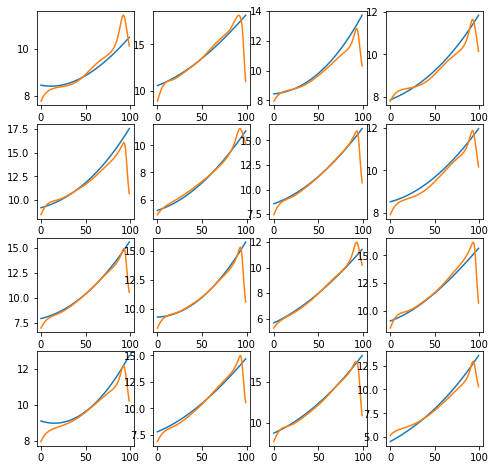

In [66]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, y1_results2.shape[0])
        ax = axs[i,j]
        ax.plot(y2[k])
        ax.plot(y1_results[k])

In [42]:
auto_test = rnn_auto(GRU, 64, 2, 2, 10, 100)
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=2500, batch_size=2000)

Epoch 1/2500


KeyboardInterrupt: 

In [30]:
x_n = np.random.uniform(0,1)
x_n

0.18650193549428062

In [31]:
x_n = np.random.uniform(0,1)

y_n1 = []
y_n2 = []
a = []
b = []
c = []
d = []

for i in range(1000000):

    a_ = np.random.normal(8, 1.5, 1)
    b_ = np.random.normal(2, 2, 1)
    c_ = np.random.normal(4, 1, 1)
    d_ = np.random.normal(0, 0.5, 1)

    y1_, y2_ = function_gen(x_n, a_, b_, c_, d_)
    
    y_n1.append(y1_)
    y_n2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)

In [34]:
np.atleast_3d(y_n1)

array([[[2.51840697]],

       [[8.30664057]],

       [[4.37181466]],

       ...,

       [[8.96849751]],

       [[7.70796708]],

       [[6.97894193]]])

In [37]:
auto_test = rnn_auto(LSTM, 64, 1, 1, 10, 1)
auto_test.fit(np.atleast_3d(y_n1), np.atleast_3d(y_n2), epochs=2500, batch_size=2000)

Epoch 1/2500
1000000/1000000 [==============================] - 21s 21us/step - loss: 111.8810
Epoch 2/2500
1000000/1000000 [==============================] - 19s 19us/step - loss: 84.6019
Epoch 3/2500
1000000/1000000 [==============================] - 19s 19us/step - loss: 33.8545
Epoch 4/2500
1000000/1000000 [==============================] - 19s 19us/step - loss: 9.3755
Epoch 5/2500
1000000/1000000 [==============================] - 19s 19us/step - loss: 5.6370
Epoch 6/2500
1000000/1000000 [==============================] - 19s 19us/step - loss: 5.2993
Epoch 7/2500
 282000/1000000 [=======>......................] - ETA: 14s - loss: 5.1871

KeyboardInterrupt: 

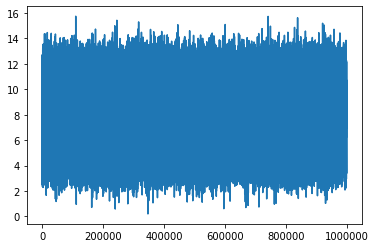

In [38]:
plt.plot(y_n1)

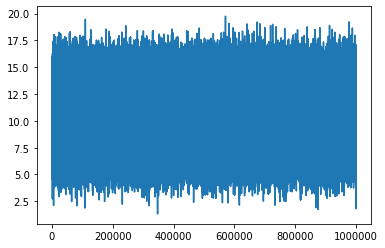

In [39]:
plt.plot(y_n2)